# Тестирование структурных продуктов

Идея: https://habr.com/ru/company/iticapital/blog/461421/

* Ребалансировка раз в год (или по желанию).
* Один низкорискованный продукт, один высокорискованный (состав может быть любой).
* Стоп на просадке любого актива до конца периода (года).

In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
import requests
import tqdm

## Данные

Ключ необходимо получить на AlphaAdvantage (https://www.alphavantage.co/support/#api-key). Система имеет ограничения на скачивание данных. Не более 5ти тикеров в минуту.

In [2]:
try:
    with open('aa.key', 'r') as f:
        aa_api = f.read()
except:
    print('ERROR: Файл aa.key не найден. Получите ключ и создайте его.')
    
len(aa_api)

16

In [3]:
url_tpl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED' \
          '&symbol={symbol}&apikey={aa_api}&datatype=csv&outputsize=full'

def prices(symbols, is_adjust=True):  # получение цен для нескольких тикеров за последние 5 лет
    df = None
    for s in symbols:  # делаем запрос цен для каждого тикера
        r = requests.get(url_tpl.format(symbol=s, aa_api=aa_api)) 
        if r.status_code == 200:  # проверяем корректный код ответа сервера
            data = pd.read_csv(io.StringIO(r.content.decode('UTF-8'))); data['symbol'] = s  # создаем pandas.DataFrame и присваиваем тикер
            if df is None:
                df = data  # присваиваем первый DataFrame
            else:
                df = pd.concat([df, data])  # соединяем последующие DataFrame
    df['dt'] = pd.to_datetime(df['timestamp'])  # конвертируем строковое поле в дату
    
    if is_adjust:
        # adjusting prices with splits & dividends
        ratio = df.adjusted_close / df.close
        df['open'] *= ratio
        df['high'] *= ratio
        df['low'] *= ratio
        df['close'] *= ratio
        df['volume'] = (df['volume'] / ratio).astype(int)
    
    columns = ['dt', 'symbol', 'open', 'high', 'low', 'close', 'volume']  # сотавляем нужные колонки
    return df[columns].set_index(['dt', 'symbol'], drop=False).sort_index()  # создаём индекс и сортируем

## Минимальные даты

Дата начала доступной истории цен.

In [4]:
def minimal_dates(prices):
    # show start dates
    return df.groupby(level=1).dt.min().sort_values()
    
    
SYMBOLS = ['MINT', 'BIL']

df = prices(SYMBOLS)
minimal_dates(df)

symbol
BIL    2007-05-30
MINT   2009-11-17
Name: dt, dtype: datetime64[ns]

# Алгоритм последовательного тестирования

In [5]:
def allow_default(df):
    """
    Разрешение ребалансировки активов в любой момент
    """
    df['allow'] = True
    return df

In [6]:
from tools import performance, drawdown, rate_for_period, Schedule


class StructuredProductMill(object):
    def __init__(self, params, prices=None, show_progress=False):
        self.params = params
        
        self._cash = params['balance']  # начинаем с доступного кэша
        self._stop_loss = params.get('stop_loss', None)  # размер стоп-лосса для закрытия позиции
        # сбрасывать цену покупки на ребалансировке для стопа
        self._reset_position_prices = params.get('reset_position_prices', False)
        self._date = params.get('start')  # дата начала теста

        self._prices = prices if prices is not None else pd.DataFrame()
        self._schedule = pd.DataFrame()
        
        # открытые позиции
        self._positions = pd.DataFrame([], columns=['symbol', 'quantity', 'amount', 'open_dt'])
        # история сделок
        self._trades = pd.DataFrame([], columns=['dt', 'symbol', 'quantity', 'price', 'commission', 'amount', 'type'])
        # кривая доходности: баланс, рыночная стоимость позиций, кэш
        self._equity = pd.DataFrame([], columns=['dt', 'balance', 'free', 'positions'])
        
        self.show_progress = show_progress

    def check_params(self):
        """
        Проверка настроек перед запуском
        """
        if len(self.params['portfolio']) < 1:
            raise Exception('Symbols in portfolio are not found.')
        elif self.params['balance'] < 5_000:
            raise Exception('Too low start balance.')
        elif self.params['freq'] not in ['week', 'month', 'year']:
            raise Exception('Rebalance frequency has to equal: week, month, year')
        
        return self
    
    def prepare(self):
        """
        Подготовка параметров для тестирования
        """
        # compute allow column
        if self.params['allow_method']:
            self.params['allow_method'](self._prices)
        
        # set portfolio parts
        for s, pct in self.params['portfolio'].items():
            self._prices.loc[(slice(None), [s]), 'size'] = pct
        
        # установка даты старта тестирования по доступной истории активов
        most_older = self._prices.groupby(level=1).dt.min().min()
        if self._date < most_older:
            print(f'INFO: Set start at: {most_older}')
            self._date = most_older
                
        # create rebalance schedule        
        sch = Schedule(self._date.date(), self._prices.index.levels[0].max().date(), 
                       dates=self._prices.index.levels[0])
        self._schedule = sch.mark_rebalance_days(self.params.get('rebalance_day', 0), 
                                                 self.params.get('freq', ''))
        
        # группировка цен по дням с даты старта
        fltr = slice(self._date, None) if self._date else slice() 
        self._grouped = self._prices[fltr].groupby(level=0)
    
    def rebalance(self, day, only_buy=False, reset_prices=True):
        """
        Основной метод ребалансировки, который вызывается в соответствии расписанию
        
        :param day: цены для всех доступных активов на дату
        :param only_buy: разрешено только докупать позиции
        :param reset_prices: обнуление цен закупки в момент ребалансировки для работы стопов
        """
        # получаем капитал: свободный кэш и рыночную стоимость позиций
        balance = self._cash + self.position_balance(day)
        
        # объединяем позиции с текущим днём из истории цен
        df = day.merge(self._positions[['quantity']], how='left', left_index=True, right_index=True)

        day['position'] = df['quantity'].fillna(0)
        day['position_to'] = 0
        day['size_order'] = 0
        
        # только разрешённые активы
        is_allow = day['allow'] == True
        # объём в процентах от исходной доли в портфеле относительно всего объема доступных активов
        day.loc[is_allow, 'size_order'] = day[is_allow]['size'] / day[is_allow]['size'].sum()
        # распределяем капитал по активам по цене открытия
        day['position_to'] = (balance * day['size_order']) // day['open']
        # формируем приказы изменения позиций
        day['order'] = day['position_to'] - day['position']
        
        # execute only buy trades
        fltr = day['order'] > 0 if only_buy else day['order'] != 0
        
        for symbol, row in day[fltr].iterrows():
            self.trade(row['dt'], symbol, row.order, row.open, 'O' if row.order > 0 else 'C')
            
        if reset_prices:
            self._positions['price'] = self._positions['amount'] / self._positions['quantity']

    @staticmethod
    def commission(quantity):
        """
        Compute commission by quantity:        
        * 15 cents for every lot (100)
        * 90 cents for every trade

        :param quantity
        """
        lots = int(abs(quantity) / 100) + 1
        return lots * 0.15 + 0.9

    def trade(self, dt, symbol, quantity, price, type_, note=None):
        """
        Исполнение сделки:
        * Проверка доступного баланса.
        * Проверка открытых позиций.
        * Обновление позиций.
        * Расчёт средней цены закупки.
        """
        # print(f'TRADE {note if note else ""}', dt.date(), symbol, quantity, price, type_)
        if np.isnan(quantity):
            print(dt, symbol, quantity, price, type_)
        
        idx = self._trades.index.max() + 1
        idx = 0 if np.isnan(idx) else idx

        comm = self.commission(quantity)
        amount = quantity * price + comm
        
        # check balance
        if self._cash < amount:
            return False
        
        self._trades.loc[
            idx,
            ['dt', 'symbol', 'quantity', 'price', 'commission', 'amount', 'type']
        ] = [pd.Timestamp(dt.date()), symbol, quantity, price, comm, -amount, type_]

        # update positions
        pos = self._positions
        if symbol in self._positions.index:
            pos.loc[symbol, 'quantity'] += quantity
            if quantity > 0:
                pos.loc[symbol, 'amount'] += amount
            else:
                pos.loc[symbol, 'amount'] = pos.loc[symbol, 'quantity'] * pos.loc[symbol, 'price']
        else:
            pos.loc[symbol, ['symbol', 'quantity', 'amount', 'open_dt']] = [symbol, quantity, amount, dt]

        # avg price
        pos['price'] = 0
        fltr = pos['quantity'] != 0
        pos.loc[fltr, 'price'] = pos[fltr]['amount'] / pos[fltr]['quantity']

        # change cash
        self._cash -= amount

        # update positions
        self._positions = pos[fltr]

    def run(self):
        """
        Основной метод тестирования:
        * Последовательно проходим по каждому периоду.
        * Ребалансируем, если разрешено.
        * Мониторим стопы.
        * Обновляем баланс в конце дня.
        """
        # add progressbar
        if self.show_progress:
            progress = tqdm.tqdm(self._grouped.groups)
        else:
            progress = self._grouped.groups
            
        for group in progress:
            if self._date and self._date >= group:
                # skip checked dates
                continue
            
            current_day = self._grouped.get_group(group)
            current_day = current_day[~current_day['size'].isna()].set_index('symbol', drop=False)
            self._date = current_day['dt'][0]
            
            if self._schedule.loc[self._date].allow == True:
                self.rebalance(current_day, reset_prices=self._reset_position_prices)
            else:
                self.monitor_positions(current_day)
                
            # update balance
            positions = self.position_balance(current_day)
            self._equity.loc[self._date, ['dt', 'balance', 'free', 'positions']] = [
                self._date, self._cash + positions, self._cash, positions]

    def monitor_positions(self, day):
        """
        Контроль открытых позиций
        """
        positions = self._positions
        if not len(positions.index) or self._stop_loss is None:
            return None
        
        df = positions.merge(day[['dt', 'low', 'close']], how='inner', left_index=True, right_index=True)
        fltr = df.price * (1 - self._stop_loss) >= df.low
        if len(df[fltr]):
            for symbol, row in df[fltr].iterrows():
                self.trade(row['dt'], symbol, -row.quantity, row.low, 'C', note='STOP')
    
    def position_balance(self, day):
        """
        Рыночная стоимость открытых позиций
        """
        positions = self._positions
        if not len(positions.index):
            return 0
        
        df = positions.merge(day[['open', 'close']], how='inner', left_index=True, right_index=True)
        df['current_value'] = df['quantity'] * df['open']
        
        return df['current_value'].sum()

    def title(self):
        name = 'Portfolio'
        return f"{name}"

    def results(self):
        if not len(self._trades):
            return {}

        # benchmark performance
        benchmark = self.params.get('benchmark', 'SPY')
        benchmark_closes = self._prices.loc[
            (slice(None), [benchmark]), ['dt', 'close']].set_index('dt').loc[
            slice(self._equity.dt.min(), None)]        

        # effective performance without deposits
        effective = performance(self._equity['balance'])
        
        # CAGR
        total_years = (effective.index.max().date() - effective.index.min().date()).days / 365
        cagr = rate_for_period(effective[-1], total_years)
        
        results = {
            'days': (self._equity.dt.max() - self._equity.dt.min()).days,
            'balance': self._equity.balance.iloc[-1],
            'CAGR, %': cagr * 100,
            'effective, %': effective[-1] * 100,
            'performance, %': performance(self._equity['balance']).iloc[-1] * 100,
            'drawdown, %': drawdown(self._equity['balance']).min() * 100,
            'benchmark perf, %': performance(benchmark_closes.close).iloc[-1] * 100,
            'benchmark dd, %': drawdown(benchmark_closes.close).min() * 100,
        }
        return results

    def print_results(self):
        results = self.results()
        results = pd.DataFrame([results], columns=results.keys())

        print(f'=== {self.title()} ===')
        print(results)

        return True

    def charts(self):
        if not len(self._equity):
            print('Error: the equity is empty.')
            return

        equity = self._equity
        
        fig = plt.figure(figsize=(15, 3), facecolor='white')

        ax_perf = fig.add_subplot(121)
        ax_dd = fig.add_subplot(122)

        # equity performance
        performance(equity['balance']).plot(ax=ax_perf, legend=True)
        
        # benchmark performance
        benchmark = self.params.get('benchmark', 'SPY')
        index_closes = self._prices.loc[(slice(None), [benchmark]), ['dt', 'close']].set_index('dt')
        benchmark_plot = performance(index_closes.loc[slice(self._equity.dt.min(), None)].close).rename(benchmark)
        benchmark_plot.plot(ax=ax_perf, legend=True, color='k', linewidth=0.7)
        # equity drawdown
        drawdown(index_closes.loc[slice(self._equity.dt.min(), None)].close).rename(benchmark).plot(ax=ax_dd, legend=True, color='k', linestyle='--', linewidth=0.5)
        drawdown(equity['balance']).plot(ax=ax_dd, legend=True, linewidth=0.7)

        ax_perf.axhline(0, color='k', linestyle='--', lw=0.5)
        ax_dd.axhline(0, color='k', linestyle='--', lw=0.5)

        fig.suptitle(self.title())

        plt.show()


# Тестирование портфелей

1. Активы и доли перечисляются в словаре `portfolio`:
 * Тикер: Доля

2. День ребалансировки `rebalance_day` внутри периода:
 * \>= 0 - слева
 * < 0 - справа

3. Ребалансировка `freq` возможна: `week`, `month`, `year`
4. Закрытие позиции по стопу `stop_loss` и обнуление цен закупке на ребалансировке `reset_position_prices`.
5. Дата `start` начала теста.

In [7]:
portfolio = {'MINT': 0.9, 'TSLA': 0.1,}
#portfolio = {'MINT': 0.9, 'AAPL': 0.1,}
#portfolio = {'MINT': 0.9, 'MSFT': 0.1,}
#portfolio = {'BIL': 0.9, 'TSLA': 0.1,}
#portfolio = {'BIL': 0.9, 'AAPL': 0.1,}

total = sum([v for k, v in portfolio.items()])
SYMBOLS = list(portfolio.keys())
print(SYMBOLS, f'Total ({len(portfolio)}): {total * 100:.2f}%')

['MINT', 'TSLA'] Total (2): 100.00%


In [8]:
params = {
    'benchmark': 'SPY',
    'balance': 100_000,
    'portfolio': portfolio,
    'rebalance_day': -1,
    'freq': 'year',
    'stop_loss': 0.1,
    'reset_position_prices': True,
    'allow_method': allow_default,
    'start': pd.to_datetime('2011-01-01'),
}
pm = StructuredProductMill(params, prices=prices(SYMBOLS + [params['benchmark']]), show_progress=True)
pm.check_params().prepare()

In [9]:
pm.run()
pm.print_results();

100%|██████████| 2155/2155 [00:11<00:00, 186.63it/s]

=== Portfolio ===
   days        balance   CAGR, %  effective, %  performance, %  drawdown, %  \
0  3126  154842.740038  5.238393     54.849011       54.849011   -15.038052   

   benchmark perf, %  benchmark dd, %  
0         182.103375       -19.338755  


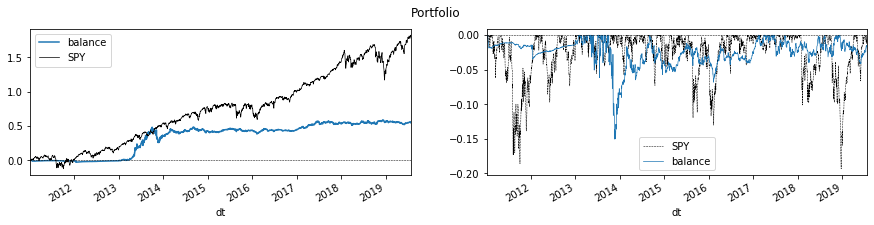

In [10]:
pm.charts()

# Ежегодный баланс

Рисование ехегодного для наглядности.

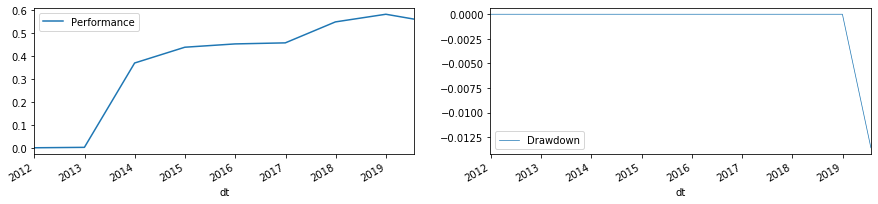

In [11]:
# aggregate columns
agg_rules = {
    'dt': 'last', 'balance': 'last',
}

# group by years
periodically = pm._equity.groupby(pd.Grouper(freq='Y')).agg(agg_rules).set_index(['dt'], drop=False)
periodically['performance'] = performance(periodically['balance'])
periodically['drawdown'] = drawdown(periodically['balance'])

# draw charts
fig = plt.figure(figsize=(15, 3), facecolor='white')
ax_perf = fig.add_subplot(121)
ax_dd = fig.add_subplot(122)
performance(periodically['balance']).rename('Performance').plot(ax=ax_perf, legend=True)
drawdown(periodically['balance']).rename('Drawdown').plot(ax=ax_dd, legend=True, linewidth=0.7);

#periodically